In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
from time import time
from IPython import display

In [ ]:
# Dataset on Google Drive
# Gave access for downloading
# ID from get link

! gdown 107_IEWAjcflF0kAACs6jWlBKjfQdZazq
! unzip Captcha-Unannotated-Dataset.zip
! mv Unannotated-Dataset Dataset

Streaming output truncated to the last 5000 lines.
  inflating: Unannotated-Dataset/5499.png  
  inflating: Unannotated-Dataset/55.png  
  inflating: Unannotated-Dataset/550.png  
  inflating: Unannotated-Dataset/5500.png  
  inflating: Unannotated-Dataset/5501.png  
  inflating: Unannotated-Dataset/5502.png  
  inflating: Unannotated-Dataset/5503.png  
  inflating: Unannotated-Dataset/5504.png  
  inflating: Unannotated-Dataset/5505.png  
  inflating: Unannotated-Dataset/5506.png  
  inflating: Unannotated-Dataset/5507.png  
  inflating: Unannotated-Dataset/5508.png  
  inflating: Unannotated-Dataset/5509.png  
  inflating: Unannotated-Dataset/551.png  
  inflating: Unannotated-Dataset/5510.png  
  inflating: Unannotated-Dataset/5511.png  
  inflating: Unannotated-Dataset/5512.png  
  inflating: Unannotated-Dataset/5513.png  
  inflating: Unannotated-Dataset/5514.png  
  inflating: Unannotated-Dataset/5515.png  
  inflating: Unannotated-Dataset/5516.png  
  inflating: Unannotated-Data

In [25]:
! unzip 9.zip
! mv 9 Dataset

Archive:  9.zip
   creating: 9/
  inflating: 9/10.png                
  inflating: 9/1000.png              
  inflating: 9/1004.png              
  inflating: 9/1005.png              
  inflating: 9/1009.png              
  inflating: 9/103.png               
  inflating: 9/1034.png              
  inflating: 9/1037.png              
  inflating: 9/1039.png              
  inflating: 9/1046.png              
  inflating: 9/1051.png              
  inflating: 9/1052.png              
  inflating: 9/1053.png              
  inflating: 9/1056.png              
  inflating: 9/106.png               
  inflating: 9/1060.png              
  inflating: 9/107.png               
  inflating: 9/1079.png              
  inflating: 9/108.png               
  inflating: 9/1083.png              
  inflating: 9/1088.png              
  inflating: 9/109.png               
  inflating: 9/1090.png              
  inflating: 9/110.png               
  inflating: 9/1101.png              
  inflating: 9/110

Found 2420 files belonging to 1 classes.

============== SAMPLE IMAGE ==============



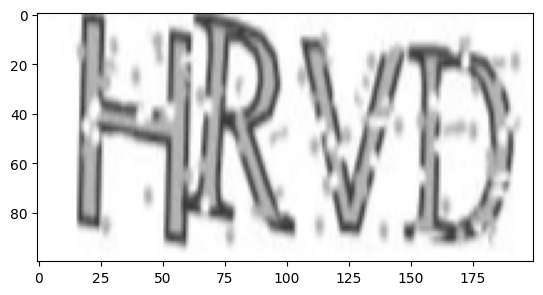

In [26]:
dataset = tf.keras.utils.image_dataset_from_directory(
    directory = "./Dataset",
    labels = None,
    # color_mode = "grayscale",
    batch_size = 64,
    image_size = (100, 200) # (height, width)
)
print("\n============== SAMPLE IMAGE ==============\n")
img, = dataset.take(1)
plt.imshow(img[0] / 255); # float32 so must be between 0 and 1 to show img

In [27]:
dataset = dataset.map(lambda x: (x - 127.5) / 127.5)

In [28]:
def Generator():
    model = tf.keras.Sequential()
    model.add(
        tf.keras.layers.Dense(
            25 * 50 * 128, # Output Units
            use_bias = False,
            input_shape = (200,)
        )
    )
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU(0.2))

    model.add(tf.keras.layers.Reshape((25, 50, 128)))
    assert model.output_shape == (None, 25, 50, 128)

    model.add(
        tf.keras.layers.Conv2DTranspose(
            128, # Num Filters
            (4, 4), # Kernel Size
            strides = (1, 1),
            padding = "same",
            use_bias = False
        )
    )
    assert model.output_shape == (None, 25, 50, 128)
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU(0.2))

    model.add(
        tf.keras.layers.Conv2DTranspose(
            64,
            (4, 4),
            strides = (2, 2),
            padding = "same",
            use_bias = False
        )
    )
    assert model.output_shape == (None, 50, 100, 64)
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU(0.2))

    model.add(
        tf.keras.layers.Conv2DTranspose(
            32,
            (4, 4),
            strides = (1, 1),
            padding = "same",
            use_bias = False
        )
    )
    assert model.output_shape == (None, 50, 100, 32)
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU(0.2))

    model.add(
        tf.keras.layers.Conv2DTranspose(
            3,
            (4, 4),
            strides = (2, 2),
            padding = "same",
            use_bias = False,
            activation = "tanh"
        )
    )
    assert model.output_shape == (None, 100, 200, 3)

    return model

In [29]:
generator = Generator()

noise = tf.random.uniform(shape = [1, 200])
generatedImage = generator(noise, training = False)

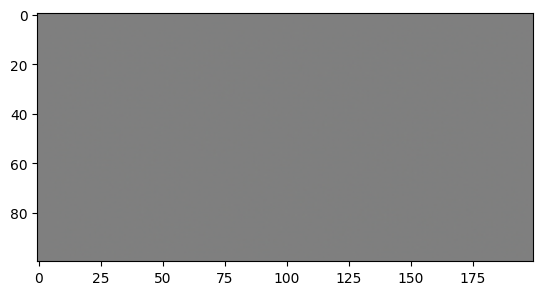

In [30]:
plt.imshow(generatedImage[0] * 0.5 + 0.5);

In [31]:
def Discriminator():
    model = tf.keras.Sequential()
    model.add(
        tf.keras.layers.Conv2D(
            32,
            (4, 4),
            strides = (1, 1),
            padding = "same",
            input_shape=[100, 200, 3]
        )
    )
    model.add(tf.keras.layers.LeakyReLU(0.2))
    model.add(tf.keras.layers.Dropout(0.25))

    model.add(
        tf.keras.layers.Conv2D(
            64,
            (4, 4),
            strides = (2, 2),
            padding = "same"
        )
    )
    model.add(tf.keras.layers.LeakyReLU(0.2))
    model.add(tf.keras.layers.Dropout(0.25))

    model.add(
        tf.keras.layers.Conv2D(
            128,
            (4, 4),
            strides = (2, 2),
            padding = "same"
        )
    )
    model.add(tf.keras.layers.LeakyReLU(0.2))
    model.add(tf.keras.layers.Dropout(0.25))

    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(1)) # Pos: Real, Neg: Fake

    return model

In [32]:
discriminator = Discriminator()
decision = discriminator(generatedImage)
print(decision)

tf.Tensor([[-0.00093623]], shape=(1, 1), dtype=float32)


In [33]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits = True)

In [34]:
def generatorLoss(outFake):
    return cross_entropy(tf.ones_like(outFake), outFake)

In [35]:
def discriminatorLoss(outReal, outFake):
    lossReal = cross_entropy(tf.ones_like(outReal), outReal)
    lossFake = cross_entropy(tf.zeros_like(outFake), outFake)
    return lossReal + lossFake

In [36]:
generatorOptimizer = tf.keras.optimizers.Adam(0.0004)
discriminatorOptimizer = tf.keras.optimizers.Adam(0.0001)

In [37]:
noiseDim = 200
numGenerated = 16

seed = tf.random.normal([numGenerated, noiseDim])

In [38]:
def trainStep(images):
    noise = tf.random.normal([64, noiseDim]) # BatchSize = 64

    with tf.GradientTape() as generatorTape, tf.GradientTape() as discriminatorTape:
      generatedImages = generator(noise, training = True)

      outReal = discriminator(images, training = True)
      outFake = discriminator(generatedImages, training = True)

      lossGenerator = generatorLoss(outFake)
      lossDiscriminator = discriminatorLoss(outReal, outFake)
      print(f"Generator Loss: {lossGenerator}")
      print(f"Discriminator Loss: {lossDiscriminator}")

      generatorGradients = generatorTape.gradient(
          lossGenerator, generator.trainable_variables
      )
      discriminatorGradients = discriminatorTape.gradient(
          lossDiscriminator, discriminator.trainable_variables
      )

      generatorOptimizer.apply_gradients(
          zip(generatorGradients, generator.trainable_variables)
      )
      discriminatorOptimizer.apply_gradients(
          zip(discriminatorGradients, discriminator.trainable_variables)
      )

In [39]:
def createImages(model, epoch, testInput):
  preds = model(testInput, training = False)

  fig = plt.figure(figsize=(14, 14))

  for i in range(preds.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(preds[i] * 0.5 + 0.5)
      plt.axis("off")

  # plt.savefig(f"image_at_epoch_{epoch}.png")
  plt.show()

In [40]:
def train(dataset, epochs):
  for epoch in range(epochs):
    tic = time()
    print(f"========== EPOCH {epoch + 1} ==========")
    for batch in dataset:
      trainStep(batch)

    display.clear_output(wait = True)
    createImages(generator, epoch + 1, seed)

    toc = time()
    print (f"Time for epoch {epoch + 1} is {toc - tic} sec")

  display.clear_output(wait = True)
  createImages(generator, epochs, seed)

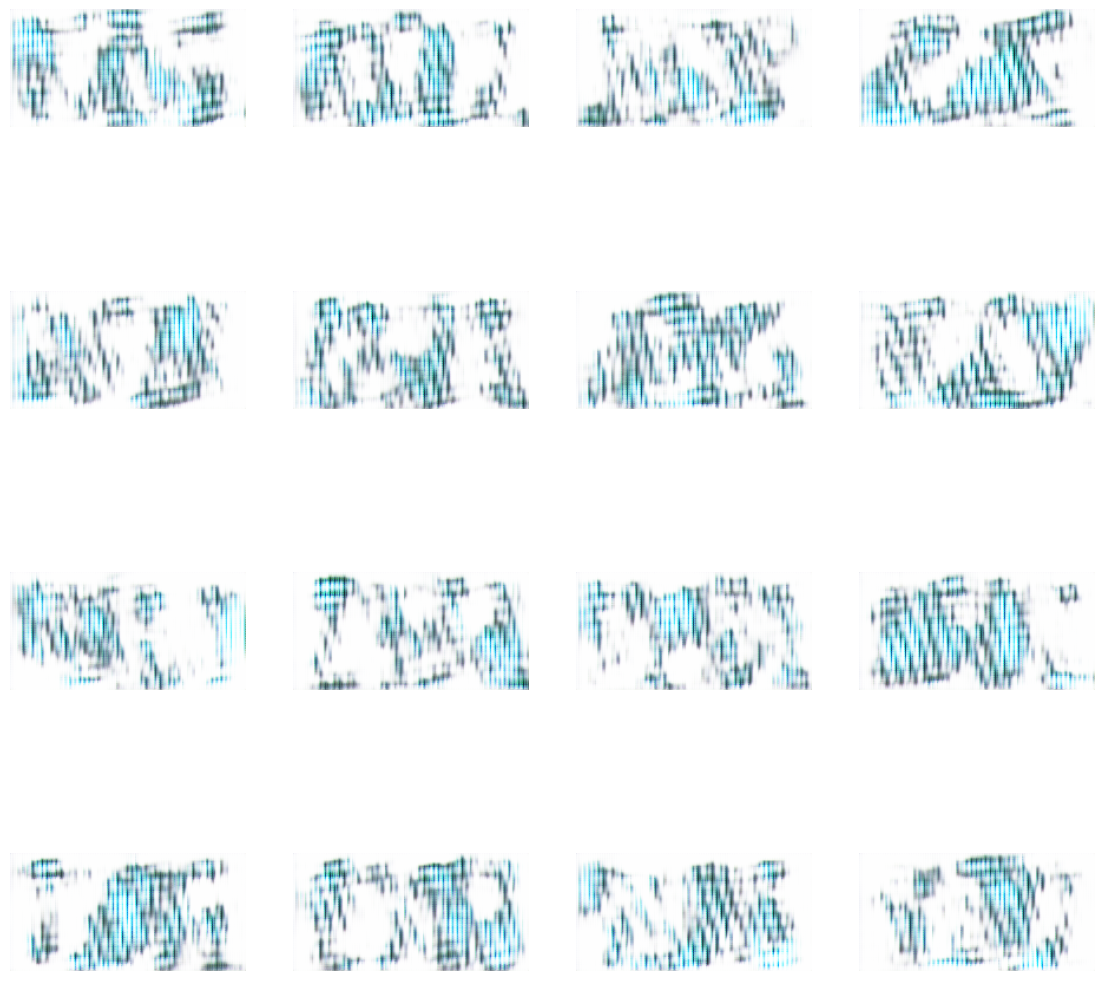

In [41]:
train(dataset, epochs = 80)

In [ ]:
# https://machinelearningmastery.com/practical-guide-to-gan-failure-modes/

In [19]:
! zip images.zip image_at_*

  adding: image_at_epoch_10.png (deflated 1%)
  adding: image_at_epoch_11.png (deflated 1%)
  adding: image_at_epoch_12.png (deflated 2%)
  adding: image_at_epoch_13.png (deflated 2%)
  adding: image_at_epoch_14.png (deflated 1%)
  adding: image_at_epoch_15.png (deflated 1%)
  adding: image_at_epoch_16.png (deflated 1%)
  adding: image_at_epoch_17.png (deflated 1%)
  adding: image_at_epoch_18.png (deflated 1%)
  adding: image_at_epoch_19.png (deflated 1%)
  adding: image_at_epoch_1.png (deflated 2%)
  adding: image_at_epoch_20.png (deflated 1%)
  adding: image_at_epoch_21.png (deflated 1%)
  adding: image_at_epoch_22.png (deflated 1%)
  adding: image_at_epoch_23.png (deflated 1%)
  adding: image_at_epoch_24.png (deflated 1%)
  adding: image_at_epoch_25.png (deflated 1%)
  adding: image_at_epoch_26.png (deflated 1%)
  adding: image_at_epoch_27.png (deflated 2%)
  adding: image_at_epoch_28.png (deflated 1%)
  adding: image_at_epoch_29.png (deflated 1%)
  adding: image_at_epoch_2.png (def

In [22]:
! rm image_at_*